In [21]:
%reset
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import glob
from collections import defaultdict
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### processing TTRUST file

In [2]:
FC_df=pd.read_table('result/foldchange_with_effect/FC_A375_effect.txt', sep='\t',engine='python')
gene_list=list(FC_df.columns[:-1])

In [3]:
## load TTRUST2 file
trust_df=pd.read_table('data/TRRUST2_TF/trrust2_TF_target.tsv', sep='\t',engine='python', header=None, usecols=[0,1,2])
trust_df.columns=['TF','target','mode']

## filter in interactions whose mode is Activation or Repression
is_directed=trust_df['mode'].map(lambda x: x in ['Activation', 'Repression'])
trust_df=trust_df.loc[is_directed]
trust_df['mode']=trust_df['mode'].map({'Activation':1, 'Repression':-1})

## filter in interactions whose target genes are in the foldchange table
is_there_target=trust_df['target'].map(lambda x: x in gene_list)
trust_df=trust_df.loc[is_there_target]

# Remove duplicated interactions
trust_df = trust_df.drop_duplicates()

# Remove self regulation
# (I think it should not be performed)

trust_df.head()
set(trust_df['mode'])
len(trust_df)
len(set(trust_df['TF']))
len(set(trust_df['target']))

## save preprocessed TF-target interactions
trust_df.to_csv('data/TRRUST2_TF/trrust2_TF_target_processed.txt',sep='\t',index=False)

,TF,target,mode
0,AATF,BAX,-1
3,AATF,MYC,1
5,ABL1,BAX,1
6,ABL1,BCL2,-1
7,ABL1,BCL6,-1


{-1, 1}

4800

627

1568

### TF activities based on target gene FCs and its z-score for each compound experiments

### 1) with formula devised by ourselves 

In [4]:
def TF_activity_calc(FC_df, TF_target_dic):
    TFA_dic=defaultdict(int)
    reg_gene=defaultdict(list)
    
    for (TF,mode),reg_gene_list in TF_target_dic.items():
        # collect target genes
        reg_gene[TF]+=reg_gene_list
        
        # sum of target gene FCs --> TF activty
        target_FC_df=FC_df[reg_gene_list]
        target_FC_sum_ds=target_FC_df.apply(sum, axis=1)
        
        # multiplied by mode: in case of repression, high negative value indicates high TF activity
        target_FC_sum_ds=target_FC_sum_ds*mode
        
        # add TF activities calculated by activating (expressing) and repressing (suppressing) target genes
        TFA_dic[TF]+=target_FC_sum_ds
    
    # dic to df
    TFA_df=pd.DataFrame(TFA_dic)

    # normalize TF activity by the number of its target genes
    for col in TFA_df.columns:
        TFA_df[col]=TFA_df[col]/len(set(reg_gene[col]))
    
    return TFA_df

def z_score(df1):
    for ind in df1.index:
        values=df1.loc[ind]
        z_values=(values-values.mean())/values.std()
        df1.loc[ind]=z_values
    
    return df1
    
# main
trust_df=pd.read_table('data/TRRUST2_TF/trrust2_TF_target_processed.txt', sep='\t',engine='python')
TF_target_dic=trust_df.groupby(['TF','mode'])['target'].apply(list).to_dict()

file_names=glob.glob('result/foldchange_with_effect/*.txt')
for file_name in file_names:
    cell = file_name.split('_')[-2]
    print('## ', cell)
    FC_df=pd.read_table(file_name, sep='\t',engine='python')
    TFA_df=TF_activity_calc(FC_df, TF_target_dic)
    TFA_Z_df=z_score(TFA_df)
    TFA_Z_df['effect']=FC_df['effect']
    TFA_Z_df.to_csv('result/TF_activity_formula/TFA_{}_f.txt'.format(cell),sep='\t',index=False)

##  A375
##  HT29


### 2) with viper (employed to the research)

### (1) run R code in "preProc5 (TF activity calculation)_viper.ipynb")

### (2) perform z-transformation

In [5]:
def z_score(df1):
    for ind in df1.index:
        values=df1.loc[ind]
        z_values=(values-values.mean())/values.std()
        df1.loc[ind]=z_values
    
    return df1

file_names=glob.glob('result/TF_activity_viper/*_v_raw.txt')
for file_name in file_names:
    print(file_name)
    TFA_df=pd.read_table(file_name, sep='\t',engine='python')
    effect=TFA_df['effect']
    TFA_df.drop(['effect'], axis=1, inplace=True)
    TFA_Z_df=z_score(TFA_df)
    TFA_Z_df['effect']=effect
    TFA_Z_df.to_csv(file_name.replace('_raw',''),sep='\t',index=False)

result/TF_activity_viper\TFA_A375_v_raw.txt
result/TF_activity_viper\TFA_HT29_v_raw.txt


### scatter plot of TF activities, computed by FORMULA, for each TF (x axis: mean, y axis: std)

## plot for the computed TF activities by formula
####  A375
## top 5 TFs involving highest std ['CREB3', 'NELFB', 'FOXL1', 'TEF', 'NR4A2']
####  HT29
## top 5 TFs involving highest std ['NELFB', 'TEF', 'ZNF160', 'RFX5', 'MAX']


C:\Users\jmjun\anaconda3\envs\theraTF\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


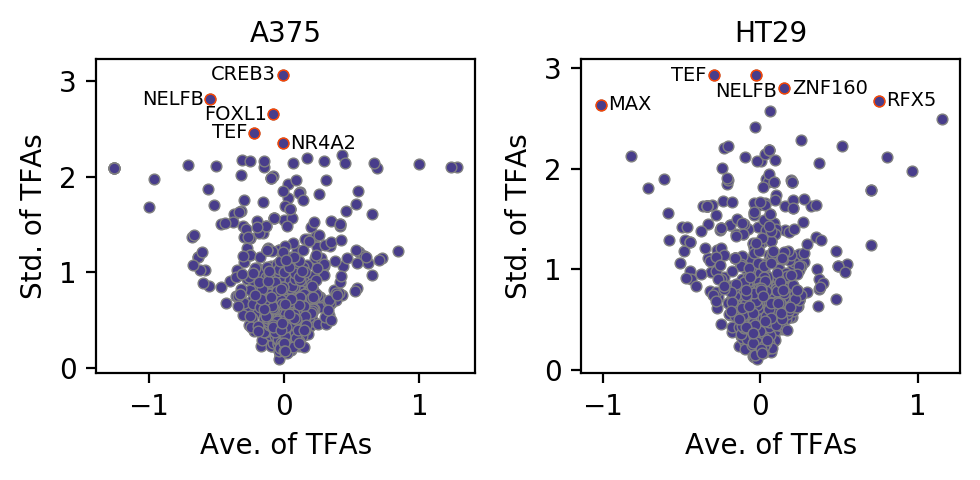

In [6]:
def scatter_plot_of_TFA_ave_std(file_name, ax):
    cell=file_name.split('_')[-2]
    print('#### ', cell)
    
    TFA_df=pd.read_table(file_name, sep='\t',engine='python')
    TFA_df.drop(['effect'], axis=1, inplace=True)
    
    # TF activity mean, std per each TF
    ave=TFA_df.apply(np.mean, axis=0)
    std=TFA_df.apply(np.std, axis=0)
    ax.scatter(ave,std,s=15, c='darkslateblue', edgecolors='grey', linewidths=0.5)
    
    # concatenate ave,std
    sig_df=pd.concat([ave,std], axis=1)
    sig_df.columns=['ave','std']
    sig_df.sort_values('std', ascending=False, inplace=True)

    TF_plot_list=list(sig_df.index[:5])
    print('## top 5 TFs involving highest std', TF_plot_list)
    for TF in TF_plot_list:
        x=sig_df.loc[TF,'ave']
        y=sig_df.loc[TF,'std']
        ax.scatter(x,y,s=15, c='darkslateblue', edgecolors='orangered', linewidths=0.5)
        if cell=='A375':
            if TF in ['NR4A2']:
                _=ax.annotate(TF, (x+0.05,y), va='center',ha='left', fontsize=7)
            else:
                _=ax.annotate(TF, (x-0.05,y), va='center',ha='right', fontsize=7)
            
            
        if cell=='HT29':
            if TF in ['ZNF160', 'RFX5', 'MAX']:
                _=ax.annotate(TF, (x+0.05,y), va='center',ha='left', fontsize=7)
            elif TF in ['TEF']:
                _=ax.annotate(TF, (x-0.05,y), va='center',ha='right', fontsize=7)
            else:
                _=ax.annotate(TF, (x-0.06,y-0.07), va='top',ha='center', fontsize=7)

    
    ax.set_title('{}'.format(cell), fontsize=10)
    ax.set_xlabel('Ave. of TFAs')
    ax.set_ylabel('Std. of TFAs')

## main
print('## plot for the computed TF activities by formula')
fig, axs = plt.subplots(1,2, figsize=(5,2.5), dpi=200)
axs=axs.flatten()

f1='result/TF_activity_formula/TFA_A375_f.txt'
scatter_plot_of_TFA_ave_std(f1, axs[0])
f2='result/TF_activity_formula/TFA_HT29_f.txt'
scatter_plot_of_TFA_ave_std(f2, axs[1])

fig.tight_layout()
fig.show()

### scatter plot of TF activities, computed by VIPER, for each TF (x axis: mean, y axis: std)

## plot for the computed TF activities by viper
####  A375
## top 5 TFs involving highest std ['MITF', 'RFWD2', 'TFDP1', 'MEF2D', 'CREB3']
####  HT29
## top 5 TFs involving highest std ['RUNX2', 'MSX1', 'HOXC6', 'MITF', 'NELFB']


C:\Users\jmjun\anaconda3\envs\theraTF\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


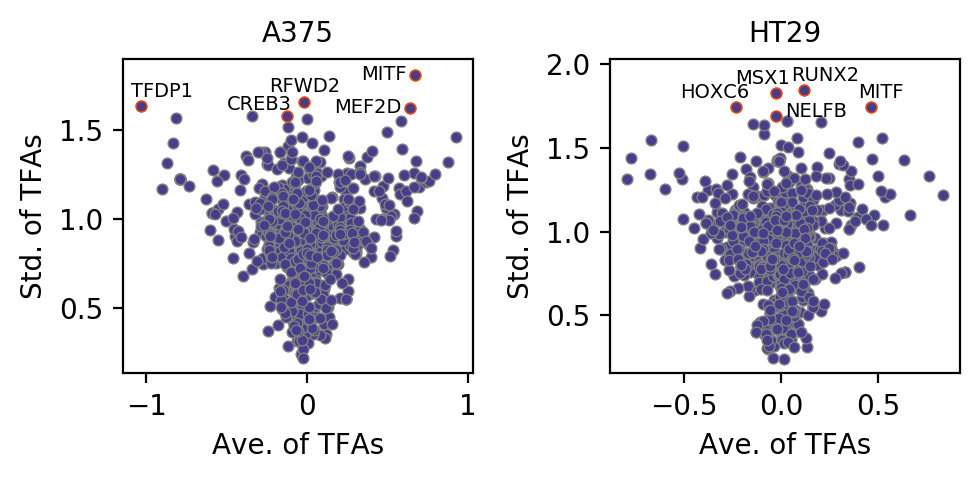

In [37]:
def scatter_plot_of_TFA_ave_std(file_name, ax):
    cell=file_name.split('_')[-2]
    print('#### ', cell)
    
    TFA_df=pd.read_table(file_name, sep='\t',engine='python')
    TFA_df.drop(['effect'], axis=1, inplace=True)
    
    # TF activity mean, std per each TF
    ave=TFA_df.apply(np.mean, axis=0)
    std=TFA_df.apply(np.std, axis=0)
    ax.scatter(ave,std,s=15, c='darkslateblue', edgecolors='grey', linewidths=0.5)
    
    # concatenate ave,std
    sig_df=pd.concat([ave,std], axis=1)
    sig_df.columns=['ave','std']
    sig_df.sort_values('std', ascending=False, inplace=True)

    TF_plot_list=list(sig_df.index[:5])
    print('## top 5 TFs involving highest std', TF_plot_list)
    for TF in TF_plot_list:
        x=sig_df.loc[TF,'ave']
        y=sig_df.loc[TF,'std']
        ax.scatter(x,y,s=15, c='darkslateblue', edgecolors='orangered', linewidths=0.5)
        if cell=='A375':
            if TF in ['MITF','MEF2D']:
                _=ax.annotate(TF, (x-0.05,y), va='center',ha='right', fontsize=7)
            elif TF in ['CREB3']:
                _=ax.annotate(TF, (x+0.03,y+0.01), va='bottom',ha='right', fontsize=7)
            elif TF in ['RFWD2']:
                _=ax.annotate(TF, (x,y+0.03), va='bottom',ha='center', fontsize=7)
            elif TF in ['TFDP1']:
                _=ax.annotate(TF, (x-0.06,y+0.03), va='bottom',ha='left', fontsize=7)            
            
        if cell=='HT29':
            if TF in ['MSX1', 'HOXC6']:
                _=ax.annotate(TF, (x+0.07,y+0.03), va='bottom',ha='right', fontsize=7)
            elif TF in ['RUNX2', 'MITF']:
                _=ax.annotate(TF, (x-0.07,y+0.03), va='bottom',ha='left', fontsize=7)
            elif TF in ['NELFB']:
                _=ax.annotate(TF, (x+0.05,y+0.03), va='center',ha='left', fontsize=7)

    if cell=='HT29':
        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]+0.1)
    ax.set_title('{}'.format(cell), fontsize=10)
    ax.set_xlabel('Ave. of TFAs')
    ax.set_ylabel('Std. of TFAs')

## main
print('## plot for the computed TF activities by viper')
fig, axs = plt.subplots(1,2, figsize=(5,2.5), dpi=200)
axs=axs.flatten()

f1='result/TF_activity_viper/TFA_A375_v.txt'
scatter_plot_of_TFA_ave_std(f1, axs[0])
f2='result/TF_activity_viper/TFA_HT29_v.txt'
scatter_plot_of_TFA_ave_std(f2, axs[1])

fig.tight_layout()
fig.show()

### pearson correlation between TF activities computed by FORMULA and VIPER for each experiment

A375
HT29


C:\Users\jmjun\anaconda3\envs\theraTF\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


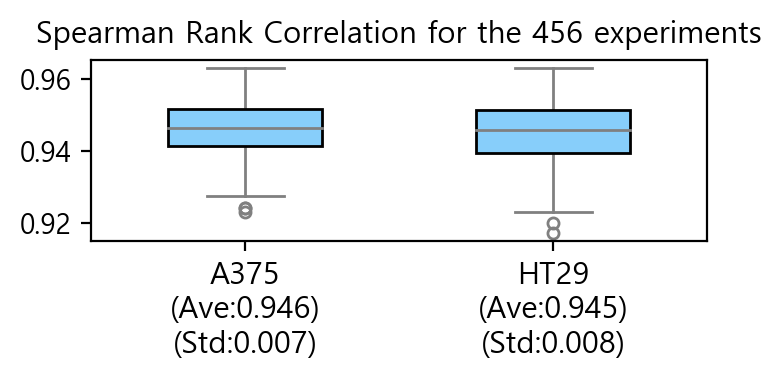

In [54]:
fig=plt.figure(figsize=(4,2), dpi=200)
ax = fig.subplots()

xticklabel=[]
for x, cell in enumerate(['A375','HT29']):
    print(cell)
    TFA_fm = pd.read_table('result/TF_activity_formula/TFA_{}_f.txt'.format(cell))
    TFA_fm.drop(['effect'], axis='columns', inplace=True)
    
    TFA_vp = pd.read_table('result/TF_activity_viper/TFA_{}_v.txt'.format(cell))
    TFA_vp.drop(['effect'], axis='columns', inplace=True)

    speaman=[]
    for ii in range(len(TFA_fm)):
        TFA_fm_each_exp=TFA_fm.iloc[ii].values
        TFA_vp_each_exp=TFA_vp.iloc[ii].values
        speaman.append(scipy.stats.spearmanr(TFA_fm_each_exp, TFA_vp_each_exp)[0])

    flierprops = dict(marker='o', markersize=4,markerfacecolor='none',markeredgecolor='grey')
    _=ax.boxplot([speaman], positions=[x], widths=0.5 ,patch_artist=True,
                 boxprops={'facecolor':'lightskyblue'}, flierprops=flierprops,
                 whiskerprops=dict(color='grey'), medianprops=dict(color='grey'), capprops=dict(color='grey'))
    xticklabel.append('{}\n(Ave:{:.3f})\n(Std:{:.3f})'.format(cell, np.mean(speaman), np.std(speaman)))
    
_=ax.set_xticklabels(xticklabel,fontsize=11)
_=ax.set_title('Spearman Rank Correlation for the 456 experiments',fontsize=11)
fig.tight_layout(h_pad=2)
fig.show()